2022-09-15

1. EC를 추가

y = 1 + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4) + EC*(x**5)

2. 두가지 경우 비교

y = 1 + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4) + w5*(x**5)

y = 1 + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4) + EC*(x**5)

y = 1 + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4) + sigmoid* w *(x**5)

2022-09-20

loss =

[f(1 + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4)) - {w1 + 2*w2 + 3*w3*(x**2) + 4*w4*(x**3)}
 + f(EC)*(x**5) - {5*f(EC)*(x**4) + d_EC*(x**5)}]**2

 [f(1 + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4)) - {w1 + 2*w2 + 3*w3*(x**2) + 4*w4*(x**3)}]**2
 + [f(EC)*(x**5) - {5*f(EC)*(x**4) + d_EC*(x**5)}]**2

2022-09-29

Work 1

1 : ODE 4차 오차 감소율 없을때 출력

2 : ODE 5차 오차 감소율 없을때 출력

3 : ODE 4차 + EC Case1 w 계수들 exact 계수들과 일치하는 경우에 대해서 비교

2022-10-10

Exam 1

exp(-x)

Error, exact(4차, 5차), train(4차, 5차, 4차+EC Case1, Case2)

Module import

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

Solve the following initial value differential equation $$ y'=\lambda y,  \quad  y(0)=y_0$$

Fuction Define

In [35]:
# analysis 함수 
def anal(x, lamb):
    return np.exp(lamb*x)

# n : w 개수, w : weight
def y(x, w, n = 4):
    y = 1         # y = 1 + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4)
    for i in range(1, n+1):
        y += w[i-1]*(x**i)
    
    return y

def yprime(x, w, n = 4):
    yprime = 0    # yprime = w1 + 2*w2*x + 3*w3*(x**2) + 4*w4*(x**3)
    for i in range(1, n + 1):
        yprime += i*w[i-1]*(x**(i-1))

    return yprime

def f(y, lamb):
    return lamb*y

def sigmoid(x):
    return tf.math.sigmoid(x)

def sigmoid_grad(x):
    return sigmoid(x) * (1 - sigmoid(x))

def neural_network(W, x):
    a1 = sigmoid(tf.experimental.numpy.dot(x, W[0]))
    return tf.experimental.numpy.dot(a1, W[1])

def d_neural_network_dx(W, x, k=1):
    return tf.experimental.numpy.dot(tf.experimental.numpy.dot(tf.transpose(W[1]), tf.transpose(W[0])**k), sigmoid_grad(x))

def net_out(W):
    return neural_network(W, 1)

def EC_predict(W, x, n):
    return net_out(W)*x**(n+1)

def d_net_out(W, x):
    return d_neural_network_dx(W, x)

# 수정
def EC_d_y(W, x, n):
    return (n+1)*(x**n)*net_out(W)

ODE

n : 차수

target_loss : 이전 학습 loss_sum의 차가 target_loss 보다 작으면 멈춤

early_stop : loss_sum 최소값 뒤로 최소값 갱신이 되지 않고, 정해진 값 이상 Epoch가 진행 되면 중단

learing_rate : 학습률

max_train_count : 최대 학습 횟수

In [44]:
def ODE_train(n = 4, target_loss = np.Inf, early_stop = np.Inf, max_train_count = np.Inf, show_w_trace = True, show_loss_trace = True, show_error = True, show_compare_analysis = True):
    # 최대 x 범위 : 0 <= x < x_max, lambda 값
    x_max = 1
    x_slice = 100
    x = tf.Variable(np.array([[i/x_slice] for i in range(0, x_max * x_slice, 1)], dtype = np.float32))
    lamb = -1.0

    # 차수, weight 개수
    w = tf.Variable(tf.random.normal(shape=(n,), dtype=tf.float32), trainable=True) # w = [weight1, weight2, weight3, weight4, ... , weight(n)]

    # 변화 w 값, loss 저장
    w_trace = []
    w_trace.append(w.numpy())
    loss_trace = []

    # 원하는 loss 값에 도달할 때 까지 Epoch 횟수 올리기
    Epoch = 0

    # y' = f(y, t)를 만족하는 y 찾는 과정
    optimizer = keras.optimizers.Adam(learning_rate=1e-3)

    # 학습 과정
    low_loss = np.inf
    low_loss_Epoch = 0
    while True:
        Epoch += 1
        loss_sum = 0.0
        for x_unit in x:
            with tf.GradientTape() as tape:
                # 예측 값
                predict = f(y(x_unit, w, n), lamb)
                # y' = f(y, t)
                loss = tf.math.sqrt(tf.square(predict - yprime(x_unit, w, n)))
                loss_sum += loss

            # Gradient 값 저장
            gradients = tape.gradient(loss, w)
            # Gradient 값 w에 적용
            optimizer.apply_gradients(zip([gradients], [w]))
        
        # w 변화값 저장
        w_trace.append(w.numpy())

        # Epoch별 loss 합 저장
        loss_sum = float(loss_sum)
        loss_trace.append(loss_sum)
        
        # early stop
        if target_loss >= loss_sum and low_loss > loss_sum:
            low_loss = loss_sum
            early_stop_w = w
            low_loss_Epoch = Epoch
        
        if low_loss_Epoch + early_stop <= Epoch:
            print('early stop')
            break
        
        if np.isnan(loss_sum):
            print('break nan')
            break

        if Epoch % 100 == 0:
            print('Epoch : {}, Loss_sum : {:.4f}, w : {}'.format(Epoch, loss_sum, w.numpy()))

        if Epoch == max_train_count:
            print('max count')
            break
        
    print('low_loss_Epoch : {}, low_Loss_sum : {:.4f}, low_loss_w : {}'.format(low_loss_Epoch, low_loss, early_stop_w))

    if show_w_trace:
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.set_title('Weight & Epoch')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Weight')
        ax.plot(w_trace, label = ['w{}'.format(i+1) for i in range(n)])
        ax.tick_params(labelsize=10)
        ax.legend(fontsize=10)
        ax.grid()

    if show_loss_trace:
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.set_title('Loss & Epoch')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.plot(loss_trace, label = 'loss')
        ax.tick_params(labelsize=10)
        ax.legend(fontsize=20)
        ax.grid()

    if show_error:
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.plot(abs(y(x, early_stop_w, n) - anal(x,lamb)), label = 'error')
        ax.tick_params(labelsize=10)
        ax.legend(fontsize=20)
        ax.grid()

    if show_compare_analysis:
        fig, ax = plt.subplots(figsize=(7, 7))
        ax.set_title('Analysis & f(lambda*y) & Error')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.plot(anal(x,lamb), label = 'analysis')
        ax.plot(y(x, early_stop_w, n), label = 'y')
        # ax.plot(y(x, w, n) + net_out(W)*x**5, label = 'add_EC')
        # ax.plot(y(x, w, n) - anal(x,lamb), label = 'error')
        ax.tick_params(labelsize=10)
        ax.legend(fontsize=20)
        ax.grid()

    return early_stop_w

ODE + EC

n : 차수

EC_n : EC weight 개수 (가로, 세로 두 곳 다 적용)

target_loss : loss_sum이 target_loss 보다 작아지면 early_stop 조건에 들어간다. 

early_stop : loss_sum 최소값 뒤로 최소값 갱신이 되지 않고, 정해진 값 이상 Epoch가 진행 되면 중단

learing_rate : 학습률

max_train_count : 최대 학습 횟수

In [45]:
def ODE_EC_Case1_train(n = 4, EC_n = 10, target_loss = np.Inf, early_stop = np.Inf, max_train_count = np.Inf, show_w_trace = True, show_loss_trace = True, show_error = True, show_compare_analysis = True):
    # 최대 x 범위 : 0 <= x < x_max, lambda 값
    x_max = 1
    x_slice = 100
    x = tf.Variable(np.array([[i/x_slice] for i in range(0, x_max * x_slice, 1)], dtype = np.float32))
    lamb = -1.0

    # 차수, weight 개수
    w = tf.Variable(tf.random.normal(shape=(n,), dtype=tf.float32), trainable=True) # w = [weight1, weight2, weight3, weight4]

    # EC, Weight 개수
    # W = [[1, EC_n], [EC_n, 1]]
    W = [tf.Variable(tf.random.normal(shape=(1, EC_n), dtype=tf.float32), trainable=True), tf.Variable(tf.random.normal(shape=(EC_n, 1), dtype=tf.float32), trainable=True)] 

    # 변화 w 값, loss 저장
    w_trace = [np.append(np.array(w.numpy()), net_out(W).numpy())]
    loss_trace = []

    # 원하는 loss 값에 도달할 때 까지 Epoch 횟수 올리기
    Epoch = 0
    
    # y' = f(y, t)를 만족하는 y 찾는 과정
    EC_optimizer = keras.optimizers.Adam(learning_rate=1e-3)

    # 학습 과정
    low_loss = np.inf
    low_loss_Epoch = 0
    while True:
        Epoch += 1
        loss_sum = 0.0
        for x_unit in x:
            with tf.GradientTape() as tape:
                # 예측 값
                _y = y(x_unit, w, n) + EC_predict(W, x_unit, n)
                predict = f(_y, lamb)
                y_prime = yprime(x_unit, w, n) + EC_d_y(W, x_unit, n)
                # y' = f(y, t)
                loss = tf.square(predict - y_prime)
                loss_sum += loss
            
            # Gradient 값 저장
            [gradients, EC_gradients] = tape.gradient(loss, [w, W])
            # Gradient 값 w에 적용
            EC_optimizer.apply_gradients(zip([gradients, EC_gradients[0], EC_gradients[1]], [w, W[0], W[1]]))
            
        # w 변화값 저장
        total_w = np.append(np.array(w.numpy()), net_out(W).numpy())
        w_trace.append(total_w)

        # Epoch별 loss 합 저장
        loss_sum = float(loss_sum)
        loss_trace.append(loss_sum)

        # early stop
        if target_loss >= loss_sum and  low_loss > loss_sum:
            low_loss = loss_sum
            early_stop_w = w, W
            low_loss_Epoch = Epoch
        
        if low_loss_Epoch + early_stop <= Epoch:
            print('early_stop')
            break

        if np.isnan(loss_sum):
            print('break nan')
            break
        
        if Epoch % 100 == 0:
            print('Epoch : {}, Loss_sum : {:.4f}, w : {}'.format(Epoch, loss_sum, total_w))

        if Epoch == max_train_count:
            print('max count')
            break
        
    print('low_loss_Epoch : {}, low_Loss_sum : {:.4f}, low_loss_w : {}'.format(low_loss_Epoch, low_loss, early_stop_w))

    if show_w_trace:
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.set_title('Weight & Epoch')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Weight')
        ax.plot(w_trace, label = ['w{}'.format(i+1) for i in range(n)] + ['NN'])
        ax.tick_params(labelsize=10)
        ax.legend(fontsize=10)
        ax.grid()
    
    if show_loss_trace:
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.set_title('Loss & Epoch')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.plot(loss_trace, label = 'loss')
        ax.tick_params(labelsize=10)
        ax.legend(fontsize=20)
        ax.grid()

    if show_error:
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.plot(abs(y(x, early_stop_w[0], n) + EC_predict(early_stop_w[1], x, n) - anal(x,lamb)), label = 'error')
        ax.tick_params(labelsize=10)
        ax.legend(fontsize=20)
        ax.grid()

    if show_compare_analysis:
        fig, ax = plt.subplots(figsize=(7, 7))
        ax.set_title('Analysis & f(lambda*y) & Error')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.plot(anal(x,lamb), label = 'analysis')
        # ax.plot(y(x, w, n), label = 'y')
        ax.plot(y(x, early_stop_w[0], n) + EC_predict(early_stop_w[1], x, n), label = 'add_EC')
        # ax.plot(y(x, w, n) - anal(x,lamb), label = 'error')
        ax.tick_params(labelsize=10)
        ax.legend(fontsize=20)
        ax.grid()

    return early_stop_w

In [46]:
def ODE_EC_Case2_train(n = 4, EC_n = 10, target_loss = np.Inf, early_stop = np.Inf, max_train_count = np.Inf, show_w_trace = True, show_loss_trace = True, show_error = True, show_compare_analysis = True):
    # 최대 x 범위 : 0 <= x < x_max, lambda 값
    x_max = 1
    x_slice = 100
    x = tf.Variable(np.array([[i/x_slice] for i in range(0, x_max * x_slice, 1)], dtype = np.float32))
    lamb = -1.0

    # 차수, weight 개수
    w = tf.Variable(tf.random.normal(shape=(n,), dtype=tf.float32), trainable=True) # w = [weight1, weight2, weight3, weight4]

    # EC, Weight 개수
    # W = [[1, EC_n], [EC_n, 1]]
    W = [tf.Variable(tf.random.normal(shape=(1, EC_n), dtype=tf.float32), trainable=True), tf.Variable(tf.random.normal(shape=(EC_n, 1), dtype=tf.float32), trainable=True)] 

    # 변화 w 값, loss 저장
    w_trace = [np.append(np.array(w.numpy()), net_out(W).numpy())]
    loss_trace = []

    # 원하는 loss 값에 도달할 때 까지 Epoch 횟수 올리기
    Epoch = 0
    
    # y' = f(y, t)를 만족하는 y 찾는 과정
    EC_optimizer = keras.optimizers.Adam(learning_rate=1e-3)

    # 학습 과정
    low_loss = np.inf
    low_loss_Epoch = 0
    while True:
        Epoch += 1
        loss_sum = 0.0
        for x_unit in x:
            with tf.GradientTape() as tape:
                # 예측 값
                _y = y(x_unit, w, n)
                EC = f(EC_predict(W, x_unit, n), lamb)
                predict = f(_y, lamb)
                y_prime = yprime(x_unit, w, n)
                d_EC = EC_d_y(W, x_unit, n)
                # y' = f(y, t)
                loss = tf.square(predict - yprime(x_unit, w, n)) + tf.square(EC - d_EC)
                loss_sum += loss
            
            # Gradient 값 저장
            [gradients, EC_gradients] = tape.gradient(loss, [w, W])
            # Gradient 값 w에 적용
            EC_optimizer.apply_gradients(zip([gradients, EC_gradients[0], EC_gradients[1]], [w, W[0], W[1]]))
            
        # w 변화값 저장
        total_w = np.append(np.array(w.numpy()), net_out(W).numpy())
        w_trace.append(total_w)

        # Epoch별 loss 합 저장
        loss_sum = float(loss_sum)
        loss_trace.append(loss_sum)

        # early stop
        if target_loss >= loss_sum and  low_loss > loss_sum:
            low_loss = loss_sum
            early_stop_w = w, W
            low_loss_Epoch = Epoch
        
        if low_loss_Epoch + early_stop <= Epoch:
            print('early_stop')
            break

        if np.isnan(loss_sum):
            print('break nan')
            break
        
        if Epoch % 100 == 0:
            print('Epoch : {}, Loss_sum : {:.4f}, w : {}'.format(Epoch, loss_sum, total_w))

        if Epoch == max_train_count:
            print('max count')
            break
        
    print('low_loss_Epoch : {}, low_Loss_sum : {:.4f}, low_loss_w : {}'.format(low_loss_Epoch, low_loss, early_stop_w))

    if show_w_trace:
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.set_title('Weight & Epoch')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Weight')
        ax.plot(w_trace, label = ['w{}'.format(i+1) for i in range(n)] + ['NN'])
        ax.tick_params(labelsize=10)
        ax.legend(fontsize=10)
        ax.grid()
    
    if show_loss_trace:
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.set_title('Loss & Epoch')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.plot(loss_trace, label = 'loss')
        ax.tick_params(labelsize=10)
        ax.legend(fontsize=20)
        ax.grid()

    if show_error:
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.plot(abs(y(x, early_stop_w[0], n) + EC_predict(early_stop_w[1], x, n) - anal(x,lamb)), label = 'error')
        ax.tick_params(labelsize=10)
        ax.legend(fontsize=20)
        ax.grid()

    if show_compare_analysis:
        fig, ax = plt.subplots(figsize=(7, 7))
        ax.set_title('Analysis & f(lambda*y) & Error')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.plot(anal(x,lamb), label = 'analysis')
        # ax.plot(y(x, w, n), label = 'y')
        ax.plot(y(x, early_stop_w[0], n) + EC_predict(early_stop_w[1], x, n), label = 'add_EC')
        # ax.plot(y(x, w, n) - anal(x,lamb), label = 'error')
        ax.tick_params(labelsize=10)
        ax.legend(fontsize=20)
        ax.grid()

    return early_stop_w

Train

----------------------------------

Epoch : 100, Loss_sum : 6.4887, w : [-0.7926137  -0.5822611   1.343397   -0.61877775]
Epoch : 200, Loss_sum : 6.2456, w : [-0.7471985  -0.5895758   1.206991   -0.51160127]
Epoch : 300, Loss_sum : 4.7672, w : [-0.7833948  -0.45655784  1.1444795  -0.52857   ]
Epoch : 400, Loss_sum : 4.3516, w : [-0.80838627 -0.39052635  1.066741   -0.49743852]
Epoch : 500, Loss_sum : 4.1511, w : [-0.8203104  -0.33278617  0.9867586  -0.4637903 ]
Epoch : 600, Loss_sum : 3.7779, w : [-0.82923955 -0.27707568  0.90450877 -0.42915362]
Epoch : 700, Loss_sum : 3.5402, w : [-0.8389556  -0.2256329   0.8224402  -0.38764033]
Epoch : 800, Loss_sum : 3.3690, w : [-0.844721   -0.17687309  0.73594874 -0.34808815]
Epoch : 900, Loss_sum : 2.9516, w : [-0.85878193 -0.12371013  0.65342516 -0.30553606]
Epoch : 1000, Loss_sum : 2.4956, w : [-0.8737624  -0.05413988  0.5780644  -0.28001523]
Epoch : 1100, Loss_sum : 2.2381, w : [-0.8876836   0.01073622  0.5099734  -0.2587242 ]
Epoch : 1200, Loss_sum : 1.8965, w : [-0.9054883   0

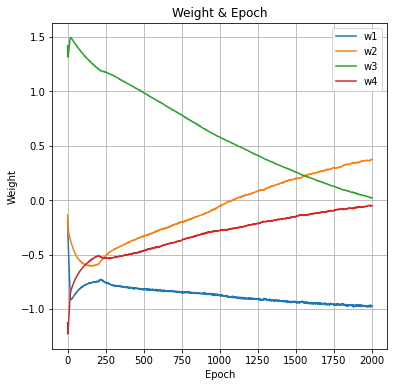

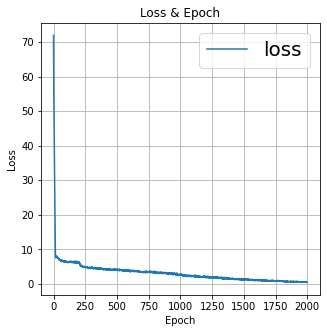

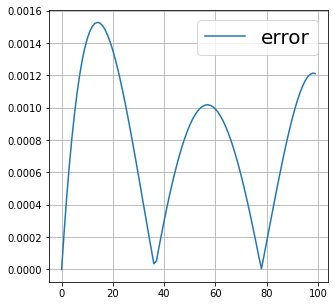

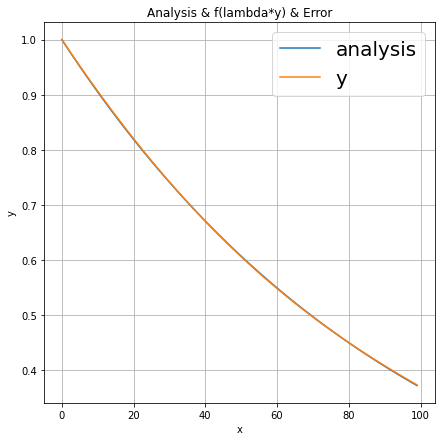

In [6]:
w4_train = ODE_train(n = 4, early_stop = 500, max_train_count = 2000)

Epoch : 100, Loss_sum : 31.5890, w : [ 0.09862771 -1.5302993   0.8574349  -0.05580043  0.07529344]
Epoch : 200, Loss_sum : 10.9584, w : [-0.50546366 -1.0184815   1.1645844  -0.09068996 -0.19514129]
Epoch : 300, Loss_sum : 8.5376, w : [-0.63371277 -0.7835384   1.1056921  -0.19757344 -0.1358317 ]
Epoch : 400, Loss_sum : 5.7219, w : [-0.72493386 -0.5505636   1.0636932  -0.29224965 -0.11622245]
Epoch : 500, Loss_sum : 4.6174, w : [-0.7762377  -0.41463602  0.98136425 -0.36026612 -0.05347077]
Epoch : 600, Loss_sum : 3.6935, w : [-0.8073107  -0.29519853  0.87885225 -0.43404487  0.02778553]
Epoch : 700, Loss_sum : 2.8497, w : [-0.85496455 -0.16560315  0.8115057  -0.49276188  0.06898584]
Epoch : 800, Loss_sum : 2.0833, w : [-0.8731338  -0.06308659  0.7384029  -0.5416279   0.11723518]
Epoch : 900, Loss_sum : 1.6126, w : [-0.9068946   0.0219176   0.6734476  -0.5802986   0.16021658]
Epoch : 1000, Loss_sum : 1.0396, w : [-0.9251418   0.09657374  0.62108874 -0.6101375   0.1877666 ]
Epoch : 1100, Los

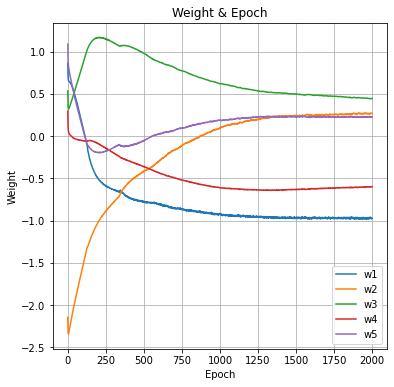

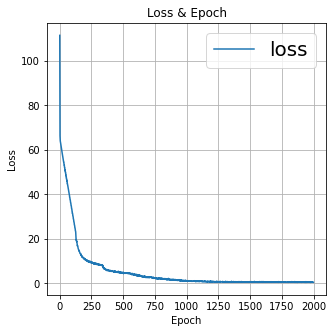

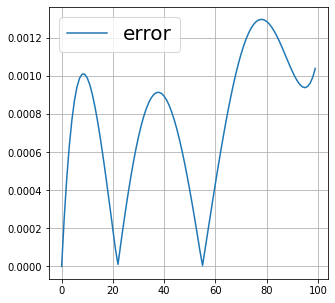

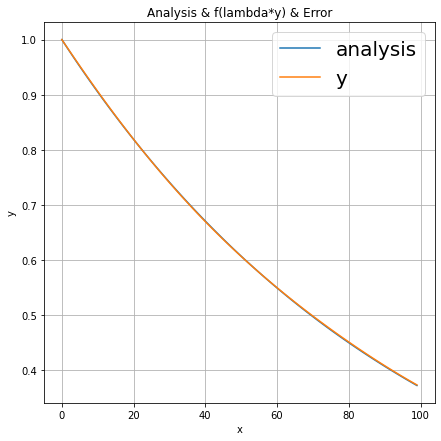

In [57]:
w5_train = ODE_train(n = 5, max_train_count = 2000)

Epoch : 100, Loss_sum : 0.0066, w : [-1.015112    0.5489992  -0.0949294  -0.19531666  0.12277192]
Epoch : 200, Loss_sum : 0.0062, w : [-0.98330957  0.475561   -0.02536895 -0.14798781  0.05766127]
Epoch : 300, Loss_sum : 0.0004, w : [-0.9970172   0.4548466  -0.02107132 -0.14225875  0.07206339]
Epoch : 400, Loss_sum : 0.0019, w : [-0.98739105  0.44460958 -0.00530436 -0.12494098  0.05684099]
Epoch : 500, Loss_sum : 0.0024, w : [-1.0433487e+00  4.1661197e-01 -9.5828186e-04 -1.0970371e-01
  6.5752208e-02]
Epoch : 600, Loss_sum : 0.0009, w : [-1.0158863e+00  4.4515112e-01 -9.8135497e-05 -1.0345519e-01
  3.3844054e-02]
Epoch : 700, Loss_sum : 0.0132, w : [-1.0021023   0.45302033 -0.00207502 -0.09295641  0.02139011]
Epoch : 800, Loss_sum : 0.0091, w : [-0.99167895  0.4093481  -0.04486275 -0.09645691  0.06936333]
Epoch : 900, Loss_sum : 0.0001, w : [-1.0013729   0.4728083  -0.05252964 -0.11049482  0.05811903]
Epoch : 1000, Loss_sum : 0.0058, w : [-1.0046616   0.45479032 -0.01916259 -0.08430186 

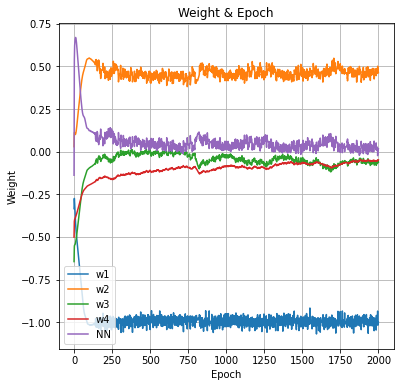

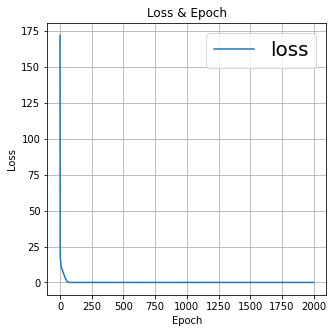

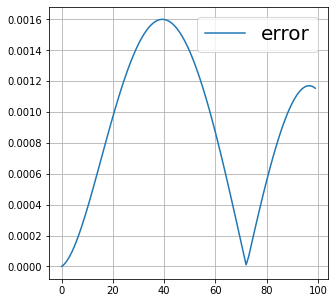

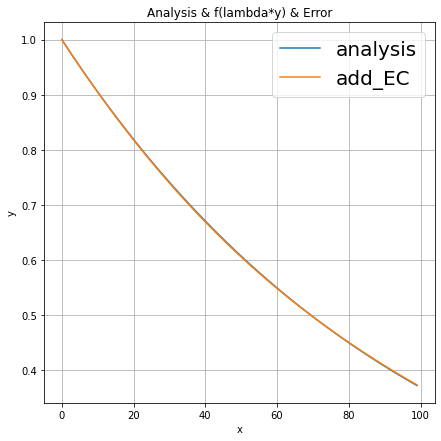

In [54]:
w4_EC_Case1_train = ODE_EC_Case1_train(n = 4, EC_n = 10, max_train_count = 2000)

Epoch : 100, Loss_sum : 14.9692, w : [-0.08178364 -1.4399298   0.5160685   0.39941567  0.        ]
Epoch : 200, Loss_sum : 1.1955, w : [-0.6732152  -0.44695747  0.7407186  -0.25739354  0.        ]
Epoch : 300, Loss_sum : 0.1246, w : [-0.8969859 -0.0760204  0.6803048 -0.3412202  0.       ]
Epoch : 400, Loss_sum : 0.0564, w : [-0.9279902   0.07514942  0.5022671  -0.27695668  0.        ]
Epoch : 500, Loss_sum : 0.0246, w : [-0.9509778   0.20204143  0.3139375  -0.19263005  0.        ]
Epoch : 600, Loss_sum : 0.0073, w : [-0.97221273  0.32133833  0.13204013 -0.10977637  0.        ]
Epoch : 700, Loss_sum : 0.0014, w : [-0.9870424   0.41781637 -0.02032843 -0.03976122  0.        ]
Epoch : 800, Loss_sum : 0.0006, w : [-1.003528    0.4799203  -0.10976619  0.00110537  0.        ]
Epoch : 900, Loss_sum : 0.0001, w : [-0.9927969   0.47184527 -0.13653481  0.02386215  0.        ]
Epoch : 1000, Loss_sum : 0.0007, w : [-0.98898464  0.49869284 -0.15226729  0.01935821  0.        ]
Epoch : 1100, Loss_sum 

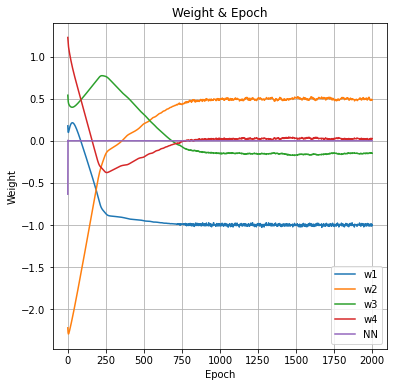

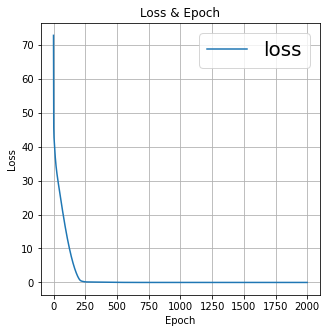

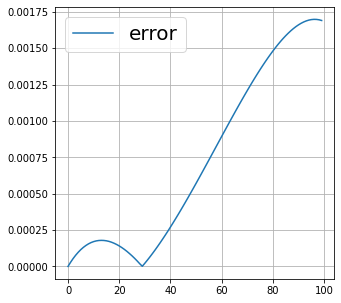

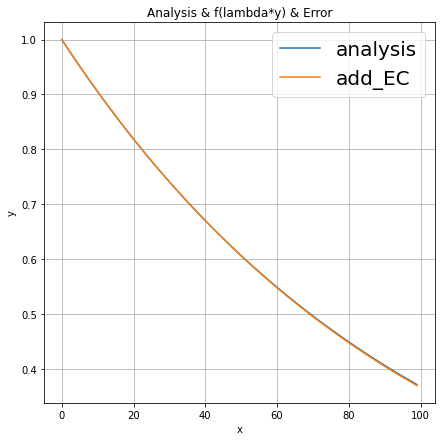

In [48]:
w4_EC_Case2_train = ODE_EC_Case2_train(n = 4, EC_n = 10, early_stop = 500, max_train_count = 2000)

In [49]:
# 2022.07.20
# 에러 그래프 부분 보강
# epoch 늘려서 학습 결과 찾기
# w 값 
# w1 = lambda와 비슷하게 -2
# w2 = 2
# w3 = -1
# w4 = 0.5
# layer 구조 확인

# 2022.08.03
# 모델 부분 input -> layer -> layer -> output
# layer 추가 할 수 있게 만들어 놓기

# 2022.08.23
# x 범위 증가 대신 개수 증가로 0 ~ 1 사이
# 코드 공유
# Error 파트 layer 추가
# Solution + Error
##  추가 학습 필요 내용 ## 
# Error에 따른 weight 업데이트 과정 수식 확인
# 비지도 학습 진행과정


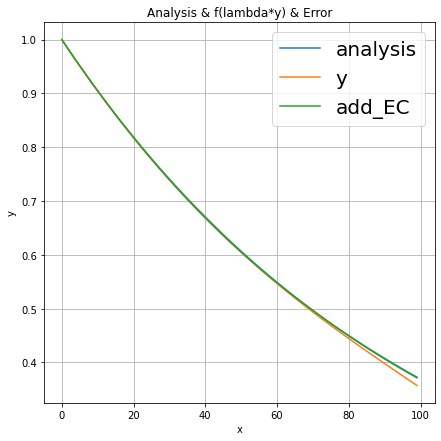

In [55]:
x_max = 1
x_slice = 100
x = tf.Variable(np.array([[i/x_slice] for i in range(0, x_max * x_slice, 1)], dtype = np.float32))
lamb = -1.0

w, W = w4_EC_Case1_train

n = 4

fig, ax = plt.subplots(figsize=(7, 7))
ax.set_title('Analysis & f(lambda*y) & Error')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.plot(anal(x,lamb), label = 'analysis')
ax.plot(y(x, w, n), label = 'y')
ax.plot(y(x, w, n)  + EC_predict(W, x, n), label = 'add_EC')
# ax.plot(y(x, w, n) - anal(x,lamb), label = 'error')
ax.tick_params(labelsize=10)
ax.legend(fontsize=20)
ax.grid()

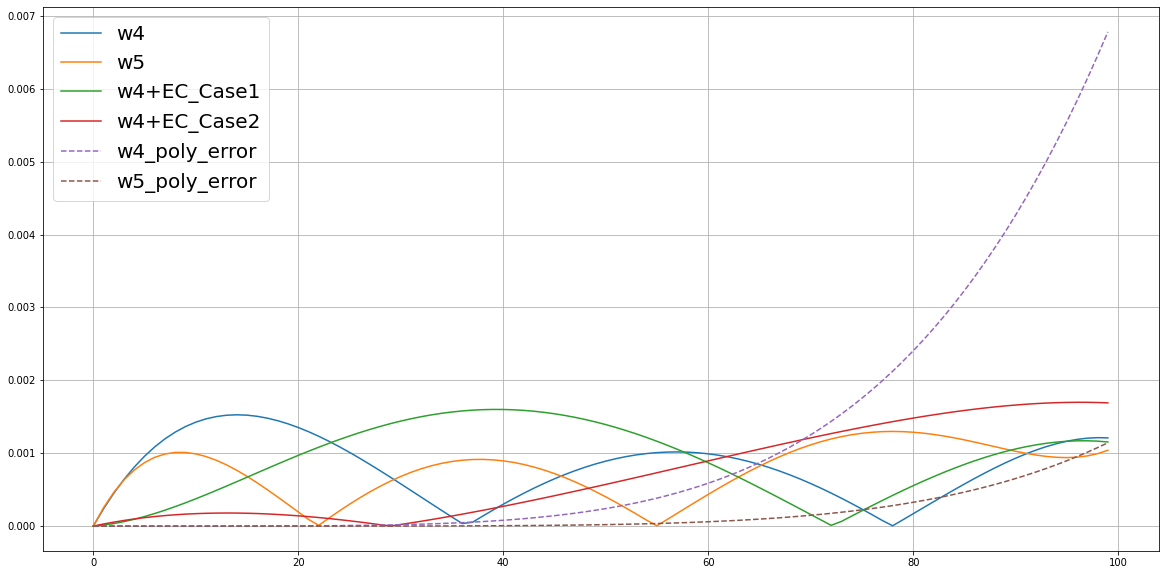

In [58]:
x_max = 1
x_slice = 100
x = tf.Variable(np.array([[i/x_slice] for i in range(0, x_max * x_slice, 1)], dtype = np.float32))
lamb = -1.0
n = 4

poly_w = [-1, 1/2, -1/6, 1/24, -1/120]

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(abs(y(x, w4_train, 4) - anal(x,lamb)), label = 'w4')
ax.plot(abs(y(x, w5_train, 5) - anal(x,lamb)), label = 'w5')
ax.plot(abs(y(x, w4_EC_Case1_train[0], 4) + EC_predict(w4_EC_Case1_train[1], x, n) - anal(x,lamb)), label = 'w4+EC_Case1')
ax.plot(abs(y(x, w4_EC_Case2_train[0], 4) + EC_predict(w4_EC_Case2_train[1], x, n) - anal(x,lamb)), label = 'w4+EC_Case2')
ax.plot(abs(y(x, poly_w[:4], 4) - anal(x,lamb)), '--', label = 'w4_poly_error')
ax.plot(abs(y(x, poly_w[:5], 5) - anal(x,lamb)), '--', label = 'w5_poly_error')
ax.tick_params(labelsize=10)
ax.legend(fontsize=20)
ax.grid()